In [1]:
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
# tf.config.gpu_options.allow_growth = True
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input


In [4]:
IMG_SIZE = 256
BATCH_SIZE = 16

# datagen = ImageDataGenerator(
#     rotation_range=20,
#     zoom_range = 0.1,  
#     width_shift_range=0.1, 
#     height_shift_range=0.1,
#     rescale=1./255,
#     validation_split=0.1)

datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range = 0.1,  
    width_shift_range=0.1, 
    height_shift_range=0.1,
    validation_split=0.1)

train_generator = datagen.flow_from_directory(
    directory = "/home/ashok/Downloads/stanford-car-dataset-by-classes-folder/car_data/car_data/train", 
    class_mode = "categorical", 
    seed = 1,
    target_size = (IMG_SIZE,IMG_SIZE), 
    subset='training',
    batch_size = BATCH_SIZE)

valid_generator = datagen.flow_from_directory(
    directory = "/home/ashok/Downloads/stanford-car-dataset-by-classes-folder/car_data/car_data/train", 
    seed = 1,
    class_mode = "categorical", 
    target_size = (IMG_SIZE,IMG_SIZE), 
    subset='validation',
    batch_size = BATCH_SIZE)

Found 14661 images belonging to 196 classes.
Found 1524 images belonging to 196 classes.


In [5]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# # Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [6]:
base_model.trainable = False

In [7]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(196, activation = 'softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 2048)        0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dense_1 (Dense)              (None, 196)               100548    
Total params: 40,465,988
Trainable params: 16,878,276
Non-trainable params: 23,587,712
___________________________________

In [10]:
base_learning_rate = 0.0001
model.compile(Adam(lr = base_learning_rate),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [12]:
history = model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs=10)

Epoch 1/10
917/917 [==============================] - 223s 244ms/step - loss: 2.3511 - accuracy: 0.3826 - val_loss: 4.4571 - val_accuracy: 0.1371
Epoch 2/10
917/917 [==============================] - 223s 243ms/step - loss: 2.2524 - accuracy: 0.4062 - val_loss: 4.3114 - val_accuracy: 0.1430
Epoch 3/10
917/917 [==============================] - 222s 243ms/step - loss: 2.1154 - accuracy: 0.4352 - val_loss: 4.1670 - val_accuracy: 0.1463
Epoch 4/10
917/917 [==============================] - 219s 239ms/step - loss: 2.0108 - accuracy: 0.4620 - val_loss: 4.1975 - val_accuracy: 0.1562
Epoch 5/10
917/917 [==============================] - 215s 234ms/step - loss: 1.9181 - accuracy: 0.4811 - val_loss: 3.9589 - val_accuracy: 0.1785
Epoch 6/10
917/917 [==============================] - 221s 241ms/step - loss: 1.8109 - accuracy: 0.5042 - val_loss: 4.0251 - val_accuracy: 0.1759
Epoch 7/10
917/917 [==============================] - 223s 243ms/step - loss: 1.7504 - accuracy: 0.5231 - val_loss: 4.2681 -

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

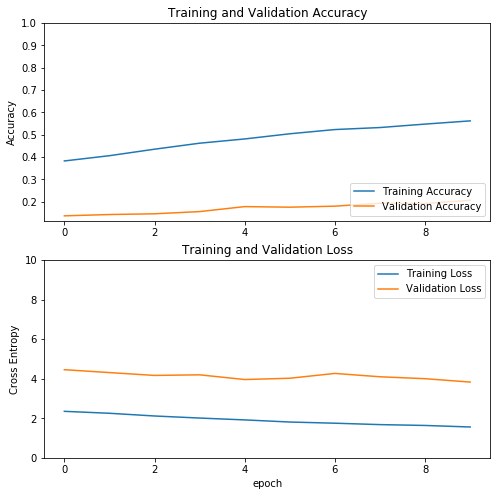

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tune the Model ##

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 60

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 2048)        0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dense_1 (Dense)              (None, 196)               100548    
Total params: 40,465,988
Trainable params: 39,524,548
Non-trainable params: 941,440
______________________________________

In [31]:
IMG_SIZE = 256
BATCH_SIZE = 8

# datagen = ImageDataGenerator(
#     rotation_range=20,
#     zoom_range = 0.1,  
#     width_shift_range=0.1, 
#     height_shift_range=0.1,
#     rescale=1./255,
#     validation_split=0.1)

datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range = 0.1,  
    width_shift_range=0.1, 
    height_shift_range=0.1,
    validation_split=0.1)

train_generator = datagen.flow_from_directory(
    directory = "/home/ashok/Downloads/stanford-car-dataset-by-classes-folder/car_data/car_data/train", 
    class_mode = "categorical", 
    seed = 1,
    target_size = (IMG_SIZE,IMG_SIZE), 
    subset='training',
    batch_size = BATCH_SIZE)

valid_generator = datagen.flow_from_directory(
    directory = "/home/ashok/Downloads/stanford-car-dataset-by-classes-folder/car_data/car_data/train", 
    seed = 1,
    class_mode = "categorical", 
    target_size = (IMG_SIZE,IMG_SIZE), 
    subset='validation',
    batch_size = BATCH_SIZE)

Found 14661 images belonging to 196 classes.
Found 1524 images belonging to 196 classes.


In [34]:
history = model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs=5)

1833/1833 [==============================] - 381s 208ms/step - loss: 0.5024 - accuracy: 0.8474 - val_loss: 1.6406 - val_accuracy: 0.5866


In [35]:
train_generator.class_indices

{'AM General Hummer SUV 2000': 0,
 'Acura Integra Type R 2001': 1,
 'Acura RL Sedan 2012': 2,
 'Acura TL Sedan 2012': 3,
 'Acura TL Type-S 2008': 4,
 'Acura TSX Sedan 2012': 5,
 'Acura ZDX Hatchback 2012': 6,
 'Aston Martin V8 Vantage Convertible 2012': 7,
 'Aston Martin V8 Vantage Coupe 2012': 8,
 'Aston Martin Virage Convertible 2012': 9,
 'Aston Martin Virage Coupe 2012': 10,
 'Audi 100 Sedan 1994': 11,
 'Audi 100 Wagon 1994': 12,
 'Audi A5 Coupe 2012': 13,
 'Audi R8 Coupe 2012': 14,
 'Audi RS 4 Convertible 2008': 15,
 'Audi S4 Sedan 2007': 16,
 'Audi S4 Sedan 2012': 17,
 'Audi S5 Convertible 2012': 18,
 'Audi S5 Coupe 2012': 19,
 'Audi S6 Sedan 2011': 20,
 'Audi TT Hatchback 2011': 21,
 'Audi TT RS Coupe 2012': 22,
 'Audi TTS Coupe 2012': 23,
 'Audi V8 Sedan 1994': 24,
 'BMW 1 Series Convertible 2012': 25,
 'BMW 1 Series Coupe 2012': 26,
 'BMW 3 Series Sedan 2012': 27,
 'BMW 3 Series Wagon 2012': 28,
 'BMW 6 Series Convertible 2007': 29,
 'BMW ActiveHybrid 5 Sedan 2012': 30,
 'BMW 

In [ ]:
model.save("Model/car_classification_ResNet50_Preprocessed_fineTuned_allData.h5")
del(model)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("Model/car_classification_ResNet50_Preprocessed_fineTuned_allData.h5")

## Checking Model Sanity on Training Data

In [36]:
import cv2
path = "/home/ashok/Downloads/cars_train/00019.jpg"
img = cv2.imread(path)
image_x = 256
image_y = 256
img = cv2.resize(img, (image_x, image_y))
img = np.array(img, dtype=np.float32)
img = np.reshape(img, (-1, image_x, image_y, 3))

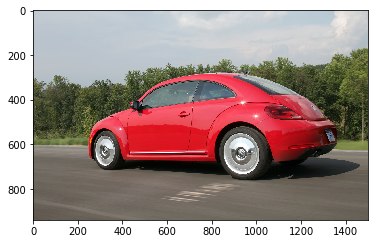

In [37]:
image = mpimg.imread(path)
plt.imshow(image)
plt.show()

In [89]:
pred = model.predict(img)
print(np.argmax(pred))
# print(class_list[np.argmax(pred)])
print(labels[np.argmax(pred)])
# train_generator.class_indices

189
Volkswagen Beetle Hatchback 2012


## Test on Unseen data (Not Done for This Model)

In [46]:
annotations = io.loadmat('/home/ashok/Downloads/cars_test_annos_withlabels.mat')
print(len(annotations['annotations'][0]))

8041


In [47]:
f_test_names = [data[5] for data in annotations['annotations'][0]]
f_test_names = np.squeeze(f_test_names)
f_test_names

array(['00001.jpg', '00002.jpg', '00003.jpg', ..., '08039.jpg',
       '08040.jpg', '08041.jpg'], dtype='<U9')

In [48]:
c_test_ints = [data[4] for data in annotations['annotations'][0]]
c_test_ints = np.squeeze(c_test_ints)
c_test_ints

array([181, 103, 145, ...,  17,  38,  32], dtype=uint8)

In [49]:
class_names_test = [class_list[index-1] for index in c_test_ints]
print(len(class_names_test))

8041


In [50]:
df_test = pd.DataFrame([f_test_names, class_names_test]).T
df_test.columns = ['test_filename', 'test_class']
df_test[:20]

,test_filename,test_class
0,00001.jpg,Suzuki Aerio Sedan 2007
1,00002.jpg,Ferrari 458 Italia Convertible 2012
2,00003.jpg,Jeep Patriot SUV 2012
3,00004.jpg,Toyota Camry Sedan 2012
4,00005.jpg,Tesla Model S Sedan 2012
5,00006.jpg,Chrysler Town and Country Minivan 2012
6,00007.jpg,GMC Terrain SUV 2012
7,00008.jpg,Mercedes-Benz S-Class Sedan 2012
8,00009.jpg,BMW X5 SUV 2007
9,00010.jpg,Chevrolet HHR SS 2010


In [66]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory="/home/ashok/Downloads/Test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False,
    seed = 1
)

Found 8041 images belonging to 1 classes.


In [67]:
test_generator.reset()

In [68]:
# STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
# STEP_SIZE_TEST
# print(STEP_SIZE_TEST)
pred = model.predict_generator(test_generator, verbose=1)

1006/1006 [==============================] - 47s 47ms/step


In [69]:
predicted_class_indices = np.argmax(pred,axis=1)
print(min(predicted_class_indices))
print((predicted_class_indices))

5
[57 10 57 ... 57 57 57]


In [70]:
labels = (train_generator.class_indices)
labels

{'AM General Hummer SUV 2000': 0,
 'Acura Integra Type R 2001': 1,
 'Acura RL Sedan 2012': 2,
 'Acura TL Sedan 2012': 3,
 'Acura TL Type-S 2008': 4,
 'Acura TSX Sedan 2012': 5,
 'Acura ZDX Hatchback 2012': 6,
 'Aston Martin V8 Vantage Convertible 2012': 7,
 'Aston Martin V8 Vantage Coupe 2012': 8,
 'Aston Martin Virage Convertible 2012': 9,
 'Aston Martin Virage Coupe 2012': 10,
 'Audi 100 Sedan 1994': 11,
 'Audi 100 Wagon 1994': 12,
 'Audi A5 Coupe 2012': 13,
 'Audi R8 Coupe 2012': 14,
 'Audi RS 4 Convertible 2008': 15,
 'Audi S4 Sedan 2007': 16,
 'Audi S4 Sedan 2012': 17,
 'Audi S5 Convertible 2012': 18,
 'Audi S5 Coupe 2012': 19,
 'Audi S6 Sedan 2011': 20,
 'Audi TT Hatchback 2011': 21,
 'Audi TT RS Coupe 2012': 22,
 'Audi TTS Coupe 2012': 23,
 'Audi V8 Sedan 1994': 24,
 'BMW 1 Series Convertible 2012': 25,
 'BMW 1 Series Coupe 2012': 26,
 'BMW 3 Series Sedan 2012': 27,
 'BMW 3 Series Wagon 2012': 28,
 'BMW 6 Series Convertible 2007': 29,
 'BMW ActiveHybrid 5 Sedan 2012': 30,
 'BMW 

In [71]:
labels = dict((v,k) for k,v in labels.items())
print(labels)

predictions = [labels[k] for k in predicted_class_indices]
len(predictions)

{0: 'AM General Hummer SUV 2000', 1: 'Acura Integra Type R 2001', 2: 'Acura RL Sedan 2012', 3: 'Acura TL Sedan 2012', 4: 'Acura TL Type-S 2008', 5: 'Acura TSX Sedan 2012', 6: 'Acura ZDX Hatchback 2012', 7: 'Aston Martin V8 Vantage Convertible 2012', 8: 'Aston Martin V8 Vantage Coupe 2012', 9: 'Aston Martin Virage Convertible 2012', 10: 'Aston Martin Virage Coupe 2012', 11: 'Audi 100 Sedan 1994', 12: 'Audi 100 Wagon 1994', 13: 'Audi A5 Coupe 2012', 14: 'Audi R8 Coupe 2012', 15: 'Audi RS 4 Convertible 2008', 16: 'Audi S4 Sedan 2007', 17: 'Audi S4 Sedan 2012', 18: 'Audi S5 Convertible 2012', 19: 'Audi S5 Coupe 2012', 20: 'Audi S6 Sedan 2011', 21: 'Audi TT Hatchback 2011', 22: 'Audi TT RS Coupe 2012', 23: 'Audi TTS Coupe 2012', 24: 'Audi V8 Sedan 1994', 25: 'BMW 1 Series Convertible 2012', 26: 'BMW 1 Series Coupe 2012', 27: 'BMW 3 Series Sedan 2012', 28: 'BMW 3 Series Wagon 2012', 29: 'BMW 6 Series Convertible 2007', 30: 'BMW ActiveHybrid 5 Sedan 2012', 31: 'BMW M3 Coupe 2012', 32: 'BMW M5

8041

In [72]:
filenames=[file[11:] for file in test_generator.filenames]
# filenames = [file[:] for file in train_generator.filenames]
print(len(filenames))
filenames


8041


['0001.jpg',
 '0002.jpg',
 '0003.jpg',
 '0004.jpg',
 '0005.jpg',
 '0006.jpg',
 '0007.jpg',
 '0008.jpg',
 '0009.jpg',
 '0010.jpg',
 '0011.jpg',
 '0012.jpg',
 '0013.jpg',
 '0014.jpg',
 '0015.jpg',
 '0016.jpg',
 '0017.jpg',
 '0018.jpg',
 '0019.jpg',
 '0020.jpg',
 '0021.jpg',
 '0022.jpg',
 '0023.jpg',
 '0024.jpg',
 '0025.jpg',
 '0026.jpg',
 '0027.jpg',
 '0028.jpg',
 '0029.jpg',
 '0030.jpg',
 '0031.jpg',
 '0032.jpg',
 '0033.jpg',
 '0034.jpg',
 '0035.jpg',
 '0036.jpg',
 '0037.jpg',
 '0038.jpg',
 '0039.jpg',
 '0040.jpg',
 '0041.jpg',
 '0042.jpg',
 '0043.jpg',
 '0044.jpg',
 '0045.jpg',
 '0046.jpg',
 '0047.jpg',
 '0048.jpg',
 '0049.jpg',
 '0050.jpg',
 '0051.jpg',
 '0052.jpg',
 '0053.jpg',
 '0054.jpg',
 '0055.jpg',
 '0056.jpg',
 '0057.jpg',
 '0058.jpg',
 '0059.jpg',
 '0060.jpg',
 '0061.jpg',
 '0062.jpg',
 '0063.jpg',
 '0064.jpg',
 '0065.jpg',
 '0066.jpg',
 '0067.jpg',
 '0068.jpg',
 '0069.jpg',
 '0070.jpg',
 '0071.jpg',
 '0072.jpg',
 '0073.jpg',
 '0074.jpg',
 '0075.jpg',
 '0076.jpg',
 '0077.jpg',

In [73]:
print(len(filenames))
print(len(predictions))
results=pd.DataFrame({"filename":filenames,
                      "class":predictions})
print(results['class'].describe())
results["class"].unique()

8041
8041
count                                                8041
unique                                                  9
top       Chevrolet Corvette Ron Fellows Edition Z06 2007
freq                                                 6163
Name: class, dtype: object


array(['Chevrolet Corvette Ron Fellows Edition Z06 2007',
       'Aston Martin Virage Coupe 2012', 'Audi S5 Coupe 2012',
       'BMW M6 Convertible 2010', 'Acura ZDX Hatchback 2012',
       'Nissan Leaf Hatchback 2012', 'Hyundai Veloster Hatchback 2012',
       'Acura TSX Sedan 2012', 'Mitsubishi Lancer Sedan 2012'],
      dtype=object)

In [85]:
print(annotations["annotations"])

[[(array([[30]], dtype=uint8), array([[52]], dtype=uint8), array([[246]], dtype=uint8), array([[147]], dtype=uint8), array([[181]], dtype=uint8), array(['00001.jpg'], dtype='<U9'))
  (array([[100]], dtype=uint8), array([[19]], dtype=uint8), array([[576]], dtype=uint16), array([[203]], dtype=uint8), array([[103]], dtype=uint8), array(['00002.jpg'], dtype='<U9'))
  (array([[51]], dtype=uint8), array([[105]], dtype=uint8), array([[968]], dtype=uint16), array([[659]], dtype=uint16), array([[145]], dtype=uint8), array(['00003.jpg'], dtype='<U9'))
  ...
  (array([[33]], dtype=uint8), array([[27]], dtype=uint8), array([[602]], dtype=uint16), array([[252]], dtype=uint8), array([[17]], dtype=uint8), array(['08039.jpg'], dtype='<U9'))
  (array([[33]], dtype=uint8), array([[142]], dtype=uint8), array([[521]], dtype=uint16), array([[376]], dtype=uint16), array([[38]], dtype=uint8), array(['08040.jpg'], dtype='<U9'))
  (array([[77]], dtype=uint8), array([[73]], dtype=uint8), array([[506]], dtype=ui

In [75]:
results.head(20)

,filename,class
0,0001.jpg,Chevrolet Corvette Ron Fellows Edition Z06 2007
1,0002.jpg,Aston Martin Virage Coupe 2012
2,0003.jpg,Chevrolet Corvette Ron Fellows Edition Z06 2007
3,0004.jpg,Chevrolet Corvette Ron Fellows Edition Z06 2007
4,0005.jpg,Chevrolet Corvette Ron Fellows Edition Z06 2007
5,0006.jpg,Chevrolet Corvette Ron Fellows Edition Z06 2007
6,0007.jpg,Chevrolet Corvette Ron Fellows Edition Z06 2007
7,0008.jpg,Chevrolet Corvette Ron Fellows Edition Z06 2007
8,0009.jpg,Chevrolet Corvette Ron Fellows Edition Z06 2007
9,0010.jpg,Chevrolet Corvette Ron Fellows Edition Z06 2007


In [ ]:
df3 = pd.merge(df, results, how='inner', on='filename')
df3.tail()

In [ ]:
df3['same'] = np.where(df3['class_x'] == df3['class_y'], "yes", "no")
df3['same'].describe()